In [592]:
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import os
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from sklearn.utils.class_weight import compute_class_weight
from torchvision import transforms
from PIL import Image
import torch
from transformers import BertTokenizer
from torchvision import models

from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

from peft import get_peft_model, LoraConfig, TaskType

import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


In [593]:
train_df = pd.read_csv("../data/fakeddit_train.tsv", sep = "\t")
val_df = pd.read_csv("../data/fakeddit_val.tsv", sep = "\t")
test_df = pd.read_csv("../data/fakeddit_test.tsv", sep = "\t")
#images in images folder with name: f"{id}.jpg"


In [594]:
# class weighting: due to class imbalance
y_train = train_df['3_way_label']

classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights = class_weights.to(DEVICE)

# to use this as loss later
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

Text & Image pytorch dataset
Text only pytorch dataset
Image only pytorch dataset

In [595]:
class NewsMultimodalDataset(Dataset):
    """Return dict: input_ids, attention_mask, image, label"""
    def __init__(self, df, tokenizer, transform, img_dir="../data/images", max_len=32):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.transform = transform
        self.img_dir = img_dir
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        title = str(row['clean_title']) if 'clean_title' in row.index else ""
        # ensure label is Python int
        label = int(row['3_way_label'])

        # Text tokenization
        tokens = self.tokenizer(
            title,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        input_ids = tokens['input_ids'].squeeze(0)
        attention_mask = tokens['attention_mask'].squeeze(0)

        # Image loading
        image_path = os.path.join(self.img_dir, f"{row['id']}.jpg")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image) 

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'image': image,
            'label': torch.tensor(label, dtype=torch.long)
        }

class TextOnlyDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=32):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        title = str(row['clean_title']) if 'clean_title' in row.index else ""
        label = int(row['3_way_label'])
        tokens = self.tokenizer(
            title,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': tokens['input_ids'].squeeze(0),
            'attention_mask': tokens['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

class ImageOnlyDataset(Dataset):
    def __init__(self, df, transform, img_dir="../data/images"):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        label = int(row['3_way_label'])
        image_path = os.path.join(self.img_dir, f"{row['id']}.jpg")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        return {
            'image': image,
            'label': torch.tensor(label, dtype=torch.long)
        }


Dataloader

In [596]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# text dataset to dataloader
train_text = TextOnlyDataset(train_df, tokenizer)
val_text = TextOnlyDataset(val_df, tokenizer)
test_text = TextOnlyDataset(test_df, tokenizer)

train_text_loader = DataLoader(train_text, batch_size=16, shuffle=True)
val_text_loader = DataLoader(val_text, batch_size=16, shuffle=True)
test_text_loader = DataLoader(test_text, batch_size=16, shuffle=True)

# image dataset to dataloader
train_image = ImageOnlyDataset(train_df, transform)
val_image = ImageOnlyDataset(val_df, transform)
test_image = ImageOnlyDataset(test_df, transform)

train_image_loader = DataLoader(train_image, batch_size=16, shuffle=True)
val_image_loader = DataLoader(val_image, batch_size=16, shuffle=True)
test_image_loader = DataLoader(test_image, batch_size=16, shuffle=True)

# text and image dataset to loader
train_ds = NewsMultimodalDataset(train_df, tokenizer, transform)
val_ds = NewsMultimodalDataset(val_df, tokenizer, transform)
test_ds = NewsMultimodalDataset(test_df, tokenizer, transform)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

BERT + RESNET & Fusion
late/feature fusion: Extract separate embeddings from each modality, then concatenate them before classification.

BERT model

In [597]:

class TextClassifier(nn.Module):
    def __init__(self, text_model_name="bert-base-uncased", num_labels=3, freeze_bert=False):
        super().__init__()
        self.bert = BertModel.from_pretrained(text_model_name)
        self.config = self.bert.config  
        hidden = self.bert.config.hidden_size
        self.classifier = nn.Linear(hidden, num_labels)

        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        return self.classifier(pooled)

# LoRA config
config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,
    r=8,
    lora_alpha=32,
    lora_dropout=0.2,
    target_modules=["query", "value"]
)

# apply LoRA to BERT first, not to classifier
bert = BertModel.from_pretrained("bert-base-uncased")
bert = get_peft_model(bert, config)

# wrap the LoRA-BERT in classifier
text_model = TextClassifier(num_labels=3)
text_model.bert = bert


ResNet model

In [598]:
class ImageClassifier(nn.Module):
    def __init__(self, num_labels=3):
        super().__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        in_feat = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_feat, num_labels)
        )
        
        # Freeze all params
        for p in self.backbone.parameters():
            p.requires_grad = False

        # Unfreeze last residual block
        for name, p in self.backbone.layer4.named_parameters():
            p.requires_grad = True
        # Unfreeze final classifier
        for p in self.backbone.fc.parameters():
            p.requires_grad = True

    def forward(self, image):
        return self.backbone(image)


Fusion of BERT and ResNet

In [599]:
class BertResNetLateFusion(nn.Module):
    def __init__(self, 
                 text_model_path="bert_text_only.pt", 
                 image_model_path="resnet_image_only.pt", 
                 num_classes=3, 
                 freeze_encoders=True):
        super().__init__()
        self.text_dropout = nn.Dropout(0.2)  
        self.img_dropout = nn.Dropout(0.2)

        # Load pretrained BERT
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.text_fc = nn.Linear(768, 512)  # reduce to 512-dim

        if text_model_path:
            try:
                text_state = torch.load(text_model_path, map_location="cpu")
                # Load only BERT weights (not classifier)
                bert_weights = {k.replace('bert.', ''): v for k, v in text_state.items() if 'bert.' in k}
                self.bert.load_state_dict(bert_weights, strict=False)
                print("Loaded pretrained BERT weights")
            except Exception as e:
                print(f"Could not load BERT weights: {e}")

        # Load pretrained ResNet
        resnet = models.resnet50(weights=None)
        resnet.fc = nn.Identity()
        self.resnet = resnet
        self.img_fc = nn.Linear(2048, 512)

        if image_model_path:
            try:
                image_state = torch.load(image_model_path, map_location="cpu")
                resnet_weights = {k.replace('resnet.', ''): v for k, v in image_state.items() if 'resnet.' in k}
                self.resnet.load_state_dict(resnet_weights, strict=False)
                print("Loaded pretrained ResNet weights")
            except Exception as e:
                print(f"Could not load ResNet weights: {e}")

        # Freeze fine-tuned encoders
        if freeze_encoders:
            for p in self.bert.parameters():
                p.requires_grad = False
            for p in self.resnet.parameters():
                p.requires_grad = False

            # Unfreeze last layers
            for name, param in self.bert.named_parameters():
                if "encoder.layer.11" in name or "pooler" in name:
                    param.requires_grad = True

            for name, param in self.resnet.named_parameters():
                if "layer4" in name:
                    param.requires_grad = True

        # Fusion head
        self.alpha = nn.Parameter(torch.tensor(0.5))  # learnable fusion weight
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    # Forward pass
    def forward(self, input_ids, attention_mask, image):
        # Text embedding
        text_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_emb = self.text_fc(text_out.pooler_output)
        text_emb = self.text_dropout(text_emb)

        # Image embedding
        img_emb = self.img_fc(self.resnet(image))
        img_emb = self.img_dropout(img_emb)

        # Weighted fusion
        fused_emb = self.alpha * text_emb + (1 - self.alpha) * img_emb
        logits = self.classifier(fused_emb)
        return logits



Train BERT text model - 2e-5 overfits

In [600]:
def evaluate_text_model(model, loader):
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu()
            all_p.extend(preds.cpu().numpy())
            all_l.extend(batch["label"].cpu().numpy())
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    avg_loss = total_loss/len(loader)
    return avg_loss, acc, f1, macro_f1


In [601]:
tr_loss = []
v_loss = []
ac = []
vac = []
f = []
vf = []
mac_f1 = []
vmac_f1 = []

def train_text_model(model, train_loader, val_loader, epochs=5, lr=1e-6): # decreased learning rate
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        avg_loss = total_loss/len(train_loader)
        tr_loss.append(avg_loss)
        ac.append(acc)
        f.append(f1)
        mac_f1.append(macro_f1)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}, Weighted F1: {f1:.4f}, Macro F1: {macro_f1:.4f}")
        
        vloss, vacc, vf1, mf1 = evaluate_text_model(model, val_loader)
        v_loss.append(vloss)
        vac.append(vacc)
        vf.append(vf1)
        vmac_f1.append(mf1)
        print(f"Validation Loss: {vloss:.4f}, Accuracy: {vacc:.4f}, Weighted F1: {vf1:.4f}, Macro F1: {mf1:.4f}")
    return model


In [602]:
text_model = TextClassifier().to(device)
text_model = train_text_model(text_model, train_text_loader, val_text_loader)

Epoch 1: 100%|██████████| 1887/1887 [23:41<00:00,  1.33it/s]


Epoch 1 | Train Loss: 0.8697, Accuracy: 0.6071, Weighted F1: 0.6077, Macro F1: 0.5397
Validation Loss: 0.6782, Accuracy: 0.6880, Weighted F1: 0.6853, Macro F1: 0.6584


Epoch 2: 100%|██████████| 1887/1887 [22:09<00:00,  1.42it/s]


Epoch 2 | Train Loss: 0.6202, Accuracy: 0.7086, Weighted F1: 0.7081, Macro F1: 0.6777
Validation Loss: 0.5594, Accuracy: 0.7264, Weighted F1: 0.7287, Macro F1: 0.6981


Epoch 3: 100%|██████████| 1887/1887 [22:22<00:00,  1.41it/s]


Epoch 3 | Train Loss: 0.5226, Accuracy: 0.7462, Weighted F1: 0.7459, Macro F1: 0.7382
Validation Loss: 0.5101, Accuracy: 0.7648, Weighted F1: 0.7655, Macro F1: 0.7635


Epoch 4: 100%|██████████| 1887/1887 [22:24<00:00,  1.40it/s]


Epoch 4 | Train Loss: 0.4714, Accuracy: 0.7701, Weighted F1: 0.7703, Macro F1: 0.7699
Validation Loss: 0.4946, Accuracy: 0.7590, Weighted F1: 0.7605, Macro F1: 0.7539


Epoch 5: 100%|██████████| 1887/1887 [22:15<00:00,  1.41it/s]


Epoch 5 | Train Loss: 0.4316, Accuracy: 0.7849, Weighted F1: 0.7851, Macro F1: 0.7909
Validation Loss: 0.4706, Accuracy: 0.7892, Weighted F1: 0.7899, Macro F1: 0.8043


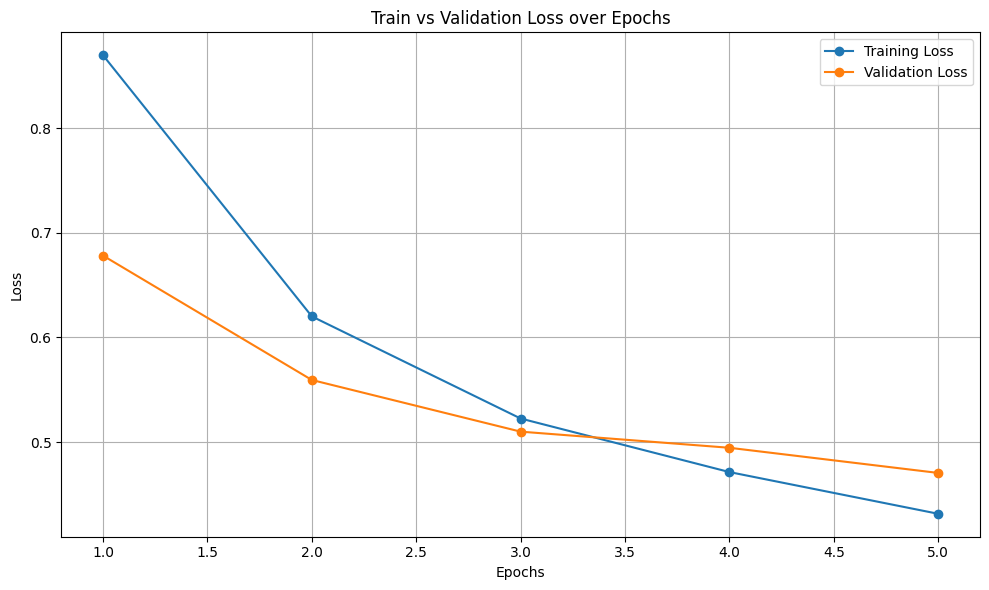

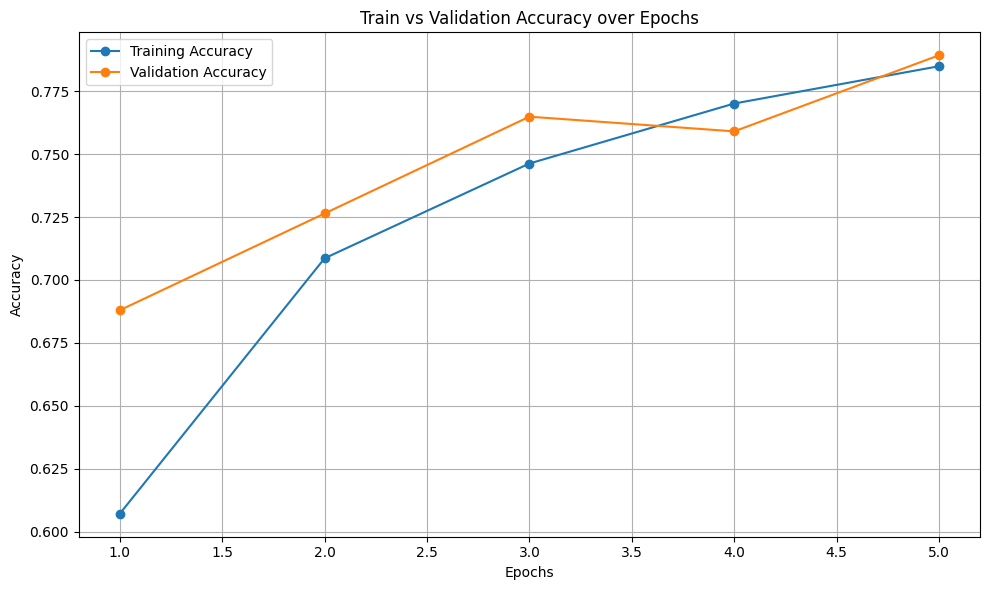

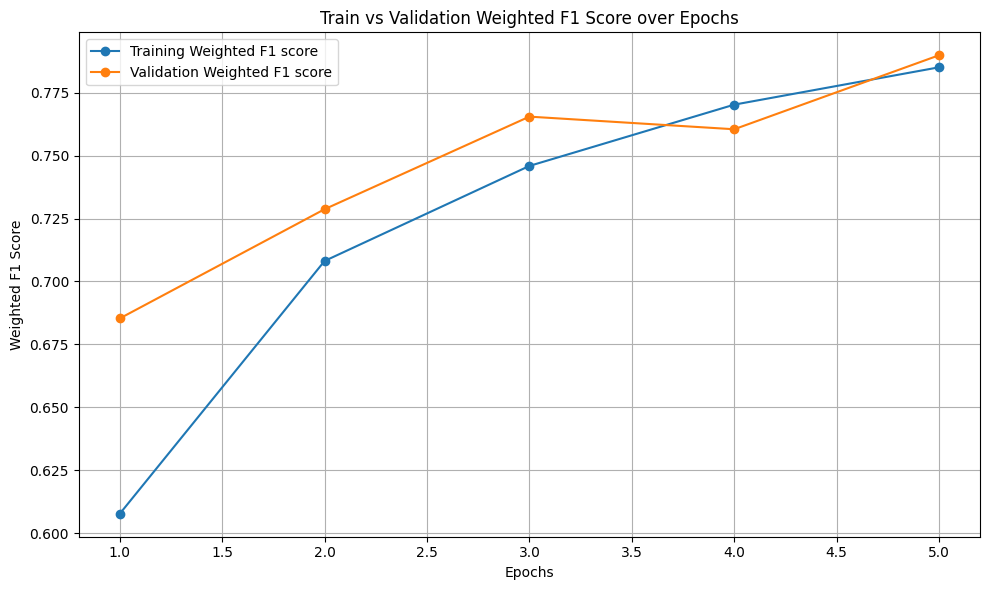

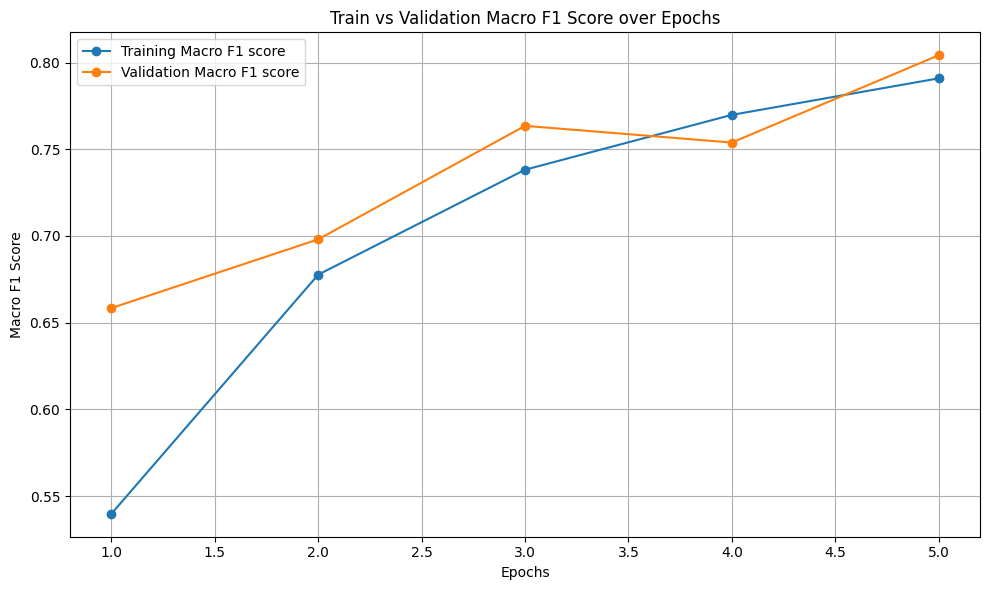

In [603]:
# Plots
EPOCHS = 5

# Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), tr_loss, marker='o', label='Training Loss')
plt.plot(range(1, EPOCHS+1), v_loss, marker='o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), ac, marker='o', label='Training Accuracy')
plt.plot(range(1, EPOCHS+1), vac, marker='o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation F1 Score
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), f, marker='o', label='Training Weighted F1 score')
plt.plot(range(1, EPOCHS+1), vf, marker='o', label='Validation Weighted F1 score')
plt.xlabel('Epochs')
plt.ylabel('Weighted F1 Score')
plt.title('Train vs Validation Weighted F1 Score over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation Macro F1 Score
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), mac_f1, marker='o', label='Training Macro F1 score')
plt.plot(range(1, EPOCHS+1), vmac_f1, marker='o', label='Validation Macro F1 score')
plt.xlabel('Epochs')
plt.ylabel('Macro F1 Score')
plt.title('Train vs Validation Macro F1 Score over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Text only BERT model performance on test set

In [604]:
# collect predictions and labels
all_preds, all_labels = [], []
test_loss, test_acc, test_wf1, test_mf1  = evaluate_text_model(text_model, test_text_loader)
print("Perfromance of Text only BERT model on test data:")
print(f"Test loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, Weighted F1: {test_wf1:.4f}, Macro F1: {test_mf1:.4f}")

Perfromance of Text only BERT model on test data:
Test loss: 0.4710, Accuracy: 0.7888, Weighted F1: 0.7897, Macro F1: 0.8071


In [605]:
# define label names
label_names = ['True', 'Misleading', 'Fake']

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Collect predictions and labels
all_preds, all_labels = [], []

text_model.eval() 

loop = tqdm(test_loader, desc='Testing')
with torch.no_grad():
    for batch in loop:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["label"].to(DEVICE)

        logits = text_model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
report = classification_report(all_labels, all_preds, target_names=label_names, digits=4)
print('\n=== Classification Report (BERT Model) ===\n')
print(report)

Testing: 100%|██████████| 236/236 [00:47<00:00,  4.92it/s]


=== Classification Report (BERT Model) ===

              precision    recall  f1-score   support

        True     0.8374    0.7815    0.8084      2082
  Misleading     0.8636    0.8444    0.8539       135
        Fake     0.7273    0.7937    0.7591      1556

    accuracy                         0.7888      3773
   macro avg     0.8094    0.8065    0.8071      3773
weighted avg     0.7929    0.7888    0.7897      3773



Save BERT model for fusion later

In [606]:
torch.save(text_model.state_dict(), "bert_text_only.pt")

Train Image only ResNet model

In [607]:
def evaluate_image_model(model, loader):
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    avg_loss = total_loss/len(loader)
    return avg_loss, acc, f1, macro_f1

In [608]:
tr_loss = []
v_loss = []
ac = []
vac = []
f = []
vf = []
mac_f1 = []
vmac_f1 = []

def train_image_model(model, train_loader, val_loader, epochs=5, lr=1e-5): # reduced learning rate
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4) # added weight decay
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        avg_loss = total_loss/len(train_loader)
        tr_loss.append(avg_loss)
        ac.append(acc)
        f.append(f1)
        mac_f1.append(macro_f1)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}, Acc: {acc:.4f}, Weighted F1: {f1:.4f}, Macro F1: {macro_f1:.4f}")

        vloss, vacc, vf1, mf1 = evaluate_image_model(model, val_loader)
        v_loss.append(vloss)
        vac.append(vacc)
        vf.append(vf1)
        vmac_f1.append(mf1)
        print(f"Validation Loss: {vloss:.4f}, Accuracy: {vacc:.4f}, Weighted F1: {vf1:.4f}, Macro F1: {mf1:.4f}")
    return model

In [609]:
image_model = ImageClassifier().to(device)
image_model = train_image_model(image_model, train_image_loader, val_image_loader)

Epoch 1: 100%|██████████| 1887/1887 [1:20:26<00:00,  2.56s/it]


Epoch 1 | Train Loss: 0.8739, Acc: 0.5587, Weighted F1: 0.5652, Macro F1: 0.5032
Validation Loss: 0.7390, Accuracy: 0.6357, Weighted F1: 0.6312, Macro F1: 0.5797


Epoch 2: 100%|██████████| 1887/1887 [1:20:25<00:00,  2.56s/it]


Epoch 2 | Train Loss: 0.7157, Acc: 0.6288, Weighted F1: 0.6316, Macro F1: 0.5792
Validation Loss: 0.6944, Accuracy: 0.6591, Weighted F1: 0.6560, Macro F1: 0.5941


Epoch 3: 100%|██████████| 1887/1887 [1:20:30<00:00,  2.56s/it]


Epoch 3 | Train Loss: 0.6695, Acc: 0.6530, Weighted F1: 0.6545, Macro F1: 0.6092
Validation Loss: 0.6834, Accuracy: 0.6683, Weighted F1: 0.6617, Macro F1: 0.6094


Epoch 4: 100%|██████████| 1887/1887 [1:20:40<00:00,  2.56s/it]


Epoch 4 | Train Loss: 0.6375, Acc: 0.6668, Weighted F1: 0.6678, Macro F1: 0.6275
Validation Loss: 0.6760, Accuracy: 0.6813, Weighted F1: 0.6774, Macro F1: 0.6284


Epoch 5: 100%|██████████| 1887/1887 [1:20:52<00:00,  2.57s/it]


Epoch 5 | Train Loss: 0.6095, Acc: 0.6787, Weighted F1: 0.6787, Macro F1: 0.6441
Validation Loss: 0.6587, Accuracy: 0.6821, Weighted F1: 0.6765, Macro F1: 0.6219


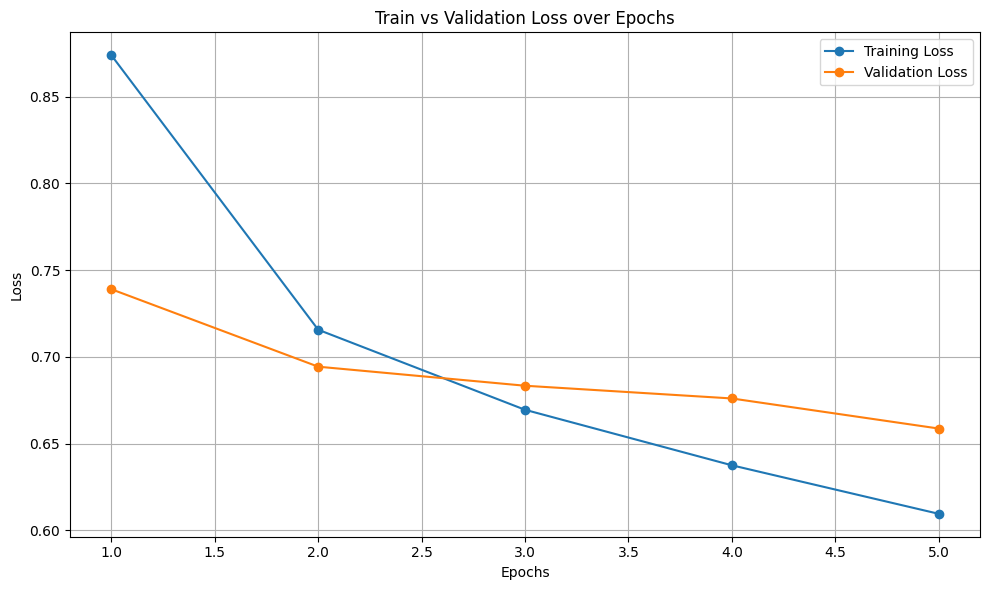

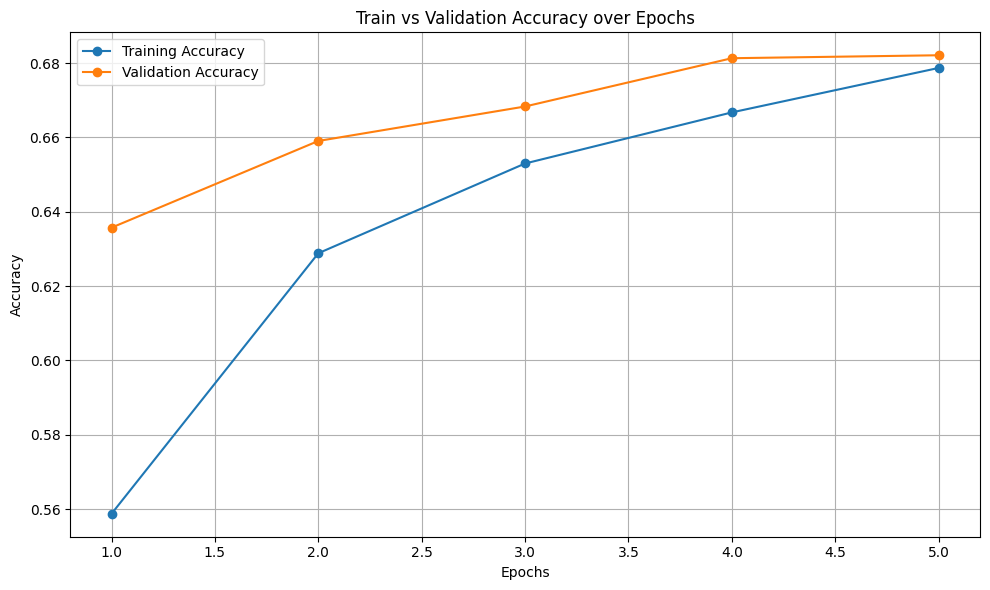

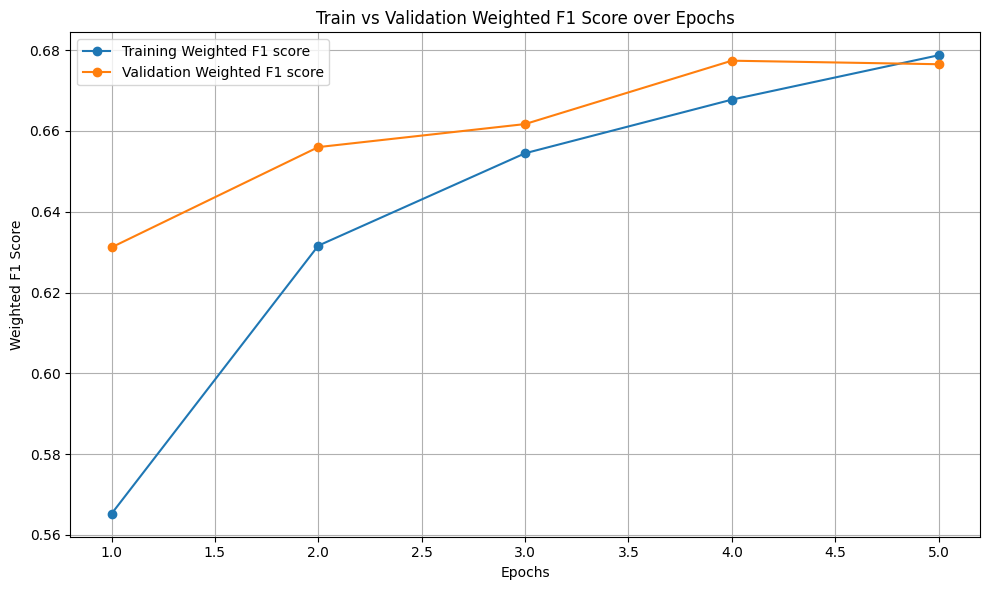

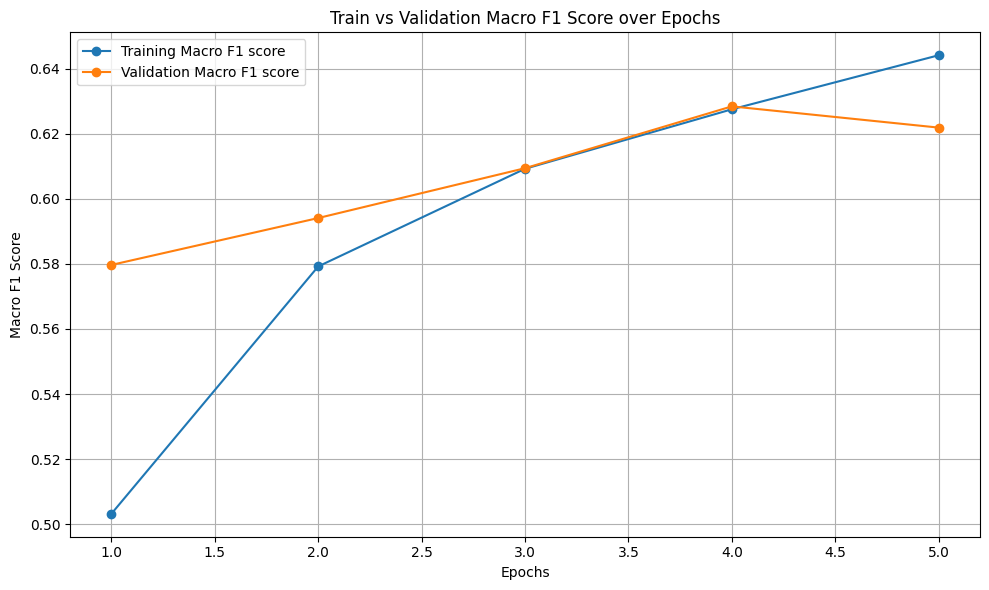

In [610]:
# plot loss, accuracy, f1

# Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), tr_loss, marker='o', label='Training Loss')
plt.plot(range(1, EPOCHS+1), v_loss, marker='o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), ac, marker='o', label='Training Accuracy')
plt.plot(range(1, EPOCHS+1), vac, marker='o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation F1 Score
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), f, marker='o', label='Training Weighted F1 score')
plt.plot(range(1, EPOCHS+1), vf, marker='o', label='Validation Weighted F1 score')
plt.xlabel('Epochs')
plt.ylabel('Weighted F1 Score')
plt.title('Train vs Validation Weighted F1 Score over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation Macro F1 Score
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), mac_f1, marker='o', label='Training Macro F1 score')
plt.plot(range(1, EPOCHS+1), vmac_f1, marker='o', label='Validation Macro F1 score')
plt.xlabel('Epochs')
plt.ylabel('Macro F1 Score')
plt.title('Train vs Validation Macro F1 Score over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Image only ResNet performance on test data

In [611]:
# collect predictions and labels
all_preds, all_labels = [], []
tloss, tacc, tf1, tmf1 = evaluate_image_model(image_model, test_image_loader)
print("Perfromance of Image only ResNet model on test data:")
print(f"Test loss: {tloss:.4f}, Accuracy: {tacc:.4f}, Weighted F1: {tf1:.4f}, Macro F1: {tmf1:.4f}")

Perfromance of Image only ResNet model on test data:
Test loss: 0.6918, Accuracy: 0.6780, Weighted F1: 0.6702, Macro F1: 0.6200


In [612]:
# Define label names
label_names = ['True', 'Misleading', 'Fake']

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Collect predictions and labels
all_preds, all_labels = [], []

image_model.eval()  # ensure dropout/bn layers are in eval mode

loop = tqdm(test_loader, desc='Testing')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        
        logits = image_model(batch["image"])
        
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["label"].cpu().numpy())

# Print classification report
report = classification_report(all_labels, all_preds, target_names=label_names, digits=4)
print('\n=== Classification Report (ResNet Model) ===\n')
print(report)


Testing: 100%|██████████| 236/236 [09:02<00:00,  2.30s/it]


=== Classification Report (ResNet Model) ===

              precision    recall  f1-score   support

        True     0.7044    0.8184    0.7572      2082
  Misleading     0.4196    0.7926    0.5487       135
        Fake     0.6979    0.4929    0.5778      1556

    accuracy                         0.6833      3773
   macro avg     0.6073    0.7013    0.6279      3773
weighted avg     0.6915    0.6833    0.6757      3773



save image only ResNet model

In [613]:
torch.save(image_model.state_dict(), "resnet_image_only.pt")

Train BERT and ResNet Fusion model

In [614]:
def evaluate_fusion_model(model, loader):
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    avg_loss = total_loss/len(loader)
    return avg_loss, acc, f1, macro_f1

In [615]:
tr_loss = []
v_loss = []
ac = []
vac = []
f = []
vf = []
mac_f1 = []
vmac_f1 = []

def train_fusion_model(model, train_loader, val_loader, epochs=5, lr=1e-6): # reduced learning rate
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-4) # added weight decay
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader, desc=f"Fusion Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        avg_loss = total_loss/len(train_loader)
        tr_loss.append(avg_loss)
        ac.append(acc)
        f.append(f1)
        mac_f1.append(macro_f1)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}, Acc: {acc:.4f}, Weighted F1: {f1:.4f}, Macro F1: {macro_f1:.4f}")

        vloss, vacc, vf1, mf1 = evaluate_fusion_model(model, val_loader)
        v_loss.append(vloss)
        vac.append(vacc)
        vf.append(vf1)
        vmac_f1.append(mf1)
        print(f"Validation Loss: {vloss:.4f}, Accuracy: {vacc:.4f}, Weighted F1: {vf1:.4f}, Macro F1: {mf1:.4f}")
        print(f"Current α: {fusion_model.alpha.item():.3f}")
    return model

In [616]:
fusion_model = BertResNetLateFusion(
    text_model_path="bert_text_only.pt",
    image_model_path="resnet_image_only.pt",
    num_classes=3,
    freeze_encoders=True 
)

fusion_model = train_fusion_model(fusion_model, train_loader, val_loader)

Loaded pretrained BERT weights
Loaded pretrained ResNet weights


Fusion Epoch 1: 100%|██████████| 1887/1887 [1:35:49<00:00,  3.05s/it]


Epoch 1 | Train Loss: 0.7735, Acc: 0.7295, Weighted F1: 0.7282, Macro F1: 0.7061
Validation Loss: 0.5660, Accuracy: 0.7876, Weighted F1: 0.7864, Macro F1: 0.7814
Current α: 0.502


Fusion Epoch 2: 100%|██████████| 1887/1887 [1:35:01<00:00,  3.02s/it]


Epoch 2 | Train Loss: 0.4739, Acc: 0.7904, Weighted F1: 0.7899, Macro F1: 0.8003
Validation Loss: 0.4846, Accuracy: 0.7837, Weighted F1: 0.7839, Macro F1: 0.7904
Current α: 0.503


Fusion Epoch 3: 100%|██████████| 1887/1887 [1:36:39<00:00,  3.07s/it]


Epoch 3 | Train Loss: 0.4257, Acc: 0.7931, Weighted F1: 0.7932, Macro F1: 0.8087
Validation Loss: 0.4916, Accuracy: 0.7882, Weighted F1: 0.7880, Macro F1: 0.7992
Current α: 0.504


Fusion Epoch 4: 100%|██████████| 1887/1887 [1:39:19<00:00,  3.16s/it]


Epoch 4 | Train Loss: 0.4189, Acc: 0.7900, Weighted F1: 0.7901, Macro F1: 0.8061
Validation Loss: 0.4821, Accuracy: 0.7858, Weighted F1: 0.7861, Macro F1: 0.7991
Current α: 0.504


Fusion Epoch 5: 100%|██████████| 1887/1887 [1:33:52<00:00,  2.99s/it]


Epoch 5 | Train Loss: 0.4178, Acc: 0.7933, Weighted F1: 0.7934, Macro F1: 0.8074
Validation Loss: 0.4756, Accuracy: 0.7861, Weighted F1: 0.7863, Macro F1: 0.7960
Current α: 0.504


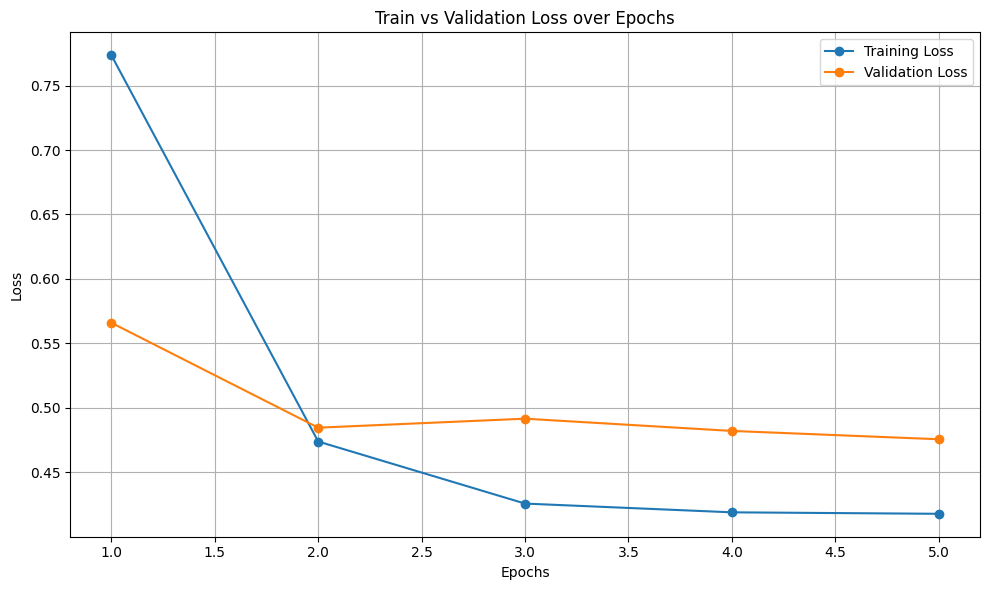

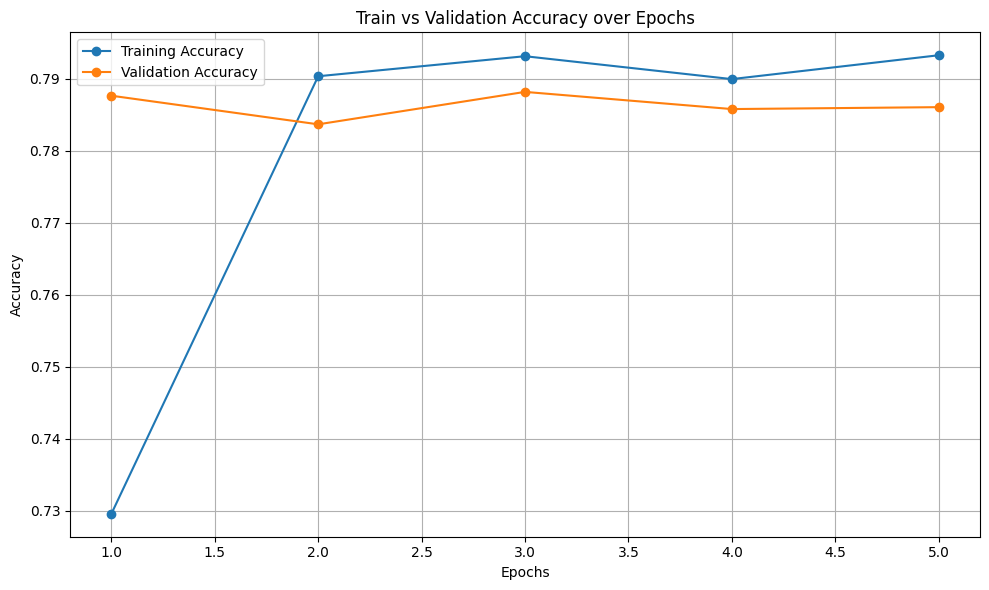

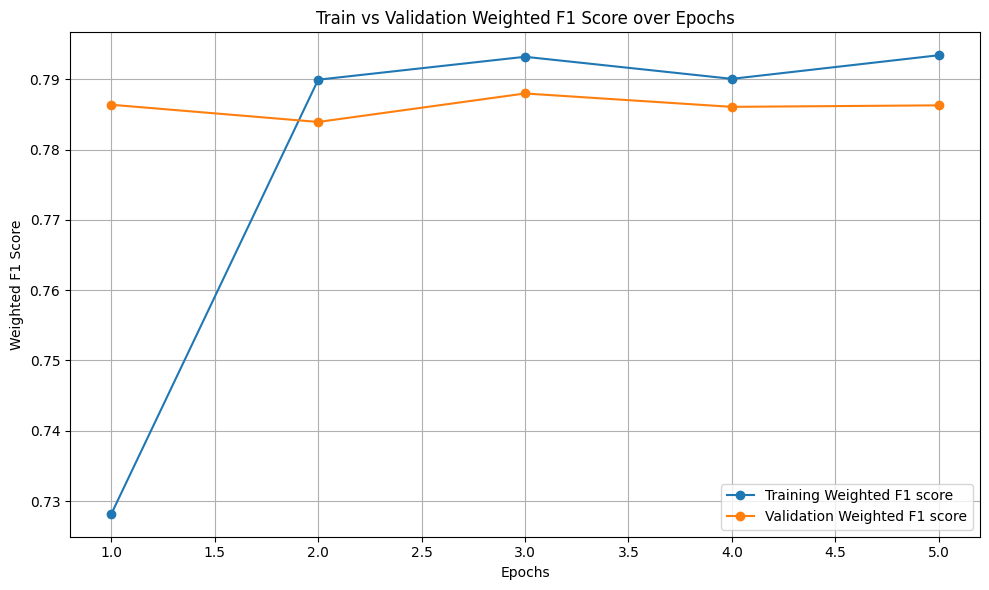

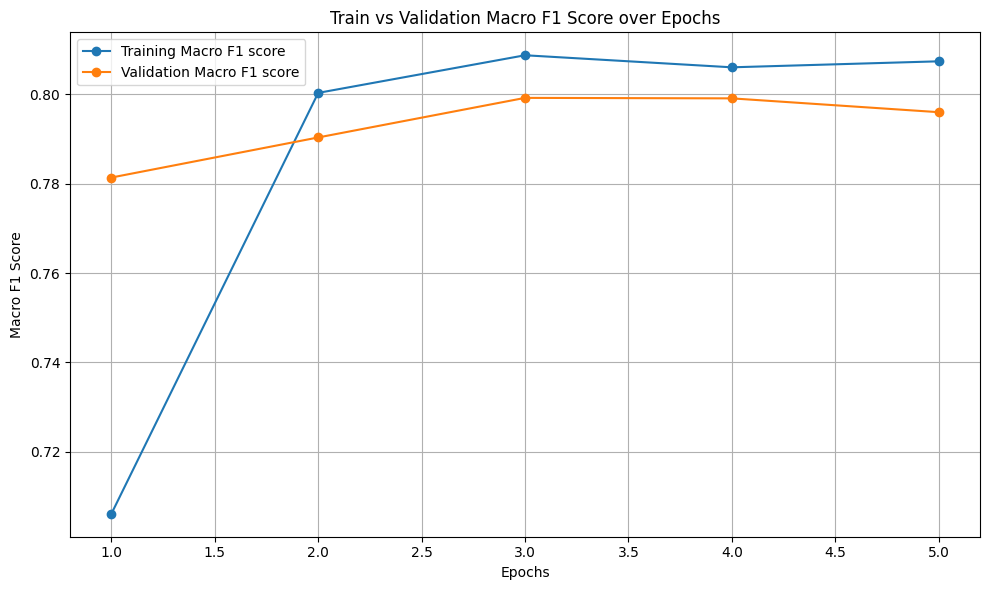

In [617]:
# plot loss, accuracy, f1

# Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), tr_loss, marker='o', label='Training Loss')
plt.plot(range(1, EPOCHS+1), v_loss, marker='o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), ac, marker='o', label='Training Accuracy')
plt.plot(range(1, EPOCHS+1), vac, marker='o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation F1 Score
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), f, marker='o', label='Training Weighted F1 score')
plt.plot(range(1, EPOCHS+1), vf, marker='o', label='Validation Weighted F1 score')
plt.xlabel('Epochs')
plt.ylabel('Weighted F1 Score')
plt.title('Train vs Validation Weighted F1 Score over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation Macro F1 Score
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), mac_f1, marker='o', label='Training Macro F1 score')
plt.plot(range(1, EPOCHS+1), vmac_f1, marker='o', label='Validation Macro F1 score')
plt.xlabel('Epochs')
plt.ylabel('Macro F1 Score')
plt.title('Train vs Validation Macro F1 Score over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

BERT-ResNet fusion model perfromance on test data

In [618]:
# collect predictions and labels
all_preds, all_labels = [], []
tloss, tacc, tf1, mtf1 = evaluate_fusion_model(fusion_model, test_loader)
print("Perfromance of Image and Text BERT-ResNet Fusion model on test data:")
print(f"Test loss: {tloss:.4f}, Accuracy: {tacc:.4f}, Weighted F1: {tf1:.4f}, Macro F1: {mtf1:.4f}")

Perfromance of Image and Text BERT-ResNet Fusion model on test data:
Test loss: 0.4580, Accuracy: 0.7882, Weighted F1: 0.7887, Macro F1: 0.7992


In [619]:
# Define label names
label_names = ['True', 'Misleading', 'Fake']

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Collect predictions and labels
all_preds, all_labels = [], []

fusion_model.eval()  

loop = tqdm(test_loader, desc='Testing')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        
        logits = fusion_model(batch["input_ids"], batch["attention_mask"], batch["image"])
        
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["label"].cpu().numpy())

# Print classification report
report = classification_report(all_labels, all_preds, target_names=label_names, digits=4)
print('\n=== Classification Report (ResNet Model) ===\n')
print(report)


Testing: 100%|██████████| 236/236 [10:39<00:00,  2.71s/it]


=== Classification Report (ResNet Model) ===

              precision    recall  f1-score   support

        True     0.8287    0.7949    0.8115      2082
  Misleading     0.7806    0.8963    0.8345       135
        Fake     0.7390    0.7699    0.7542      1556

    accuracy                         0.7882      3773
   macro avg     0.7828    0.8204    0.8000      3773
weighted avg     0.7900    0.7882    0.7887      3773



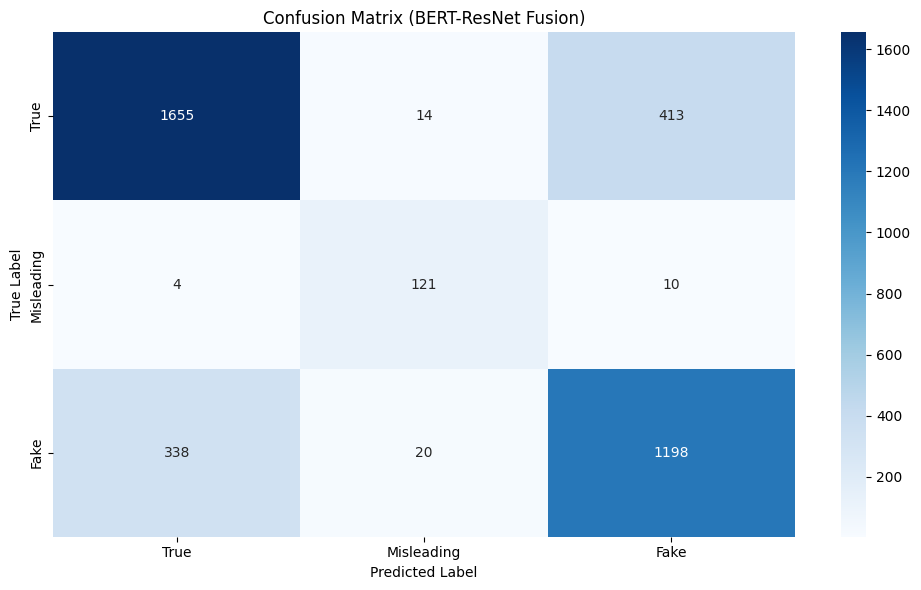

In [620]:
# plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (BERT-ResNet Fusion)')
plt.tight_layout()
plt.show()

Plot ROC-AUC curves

In [621]:
# binarize labels for ROC and precision-recall curves
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]

# get prediction probabilities
all_probs = []
loop = tqdm(test_loader, desc='Collecting probabilities')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        logits = model(batch["input_ids"], batch["attention_mask"], batch["image"])
        probs = torch.softmax(logits, dim=-1)
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)

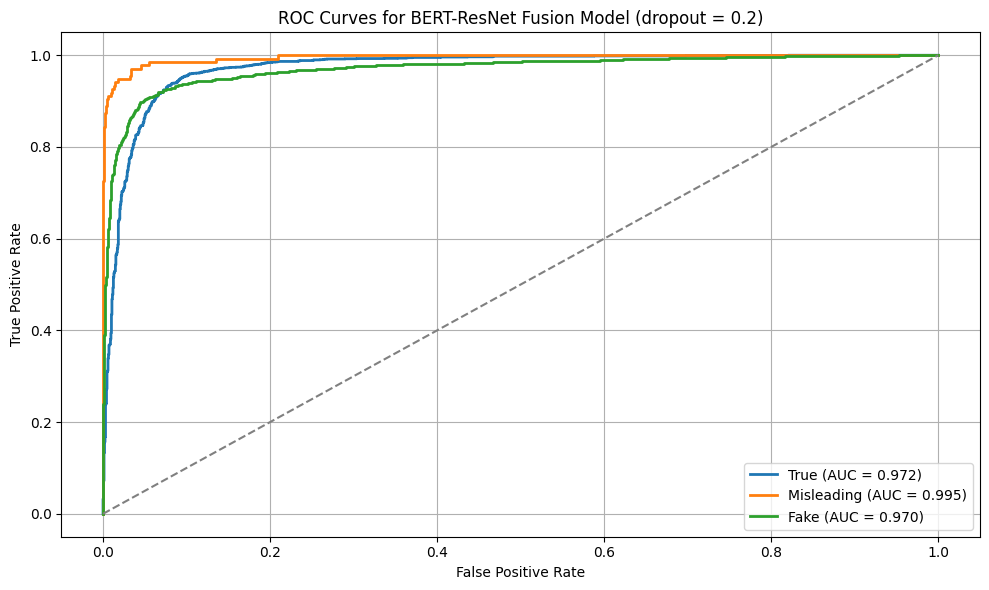

In [622]:
# plot ROC curves
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{name} (AUC = {roc_auc[i]:.3f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for BERT-ResNet Fusion Model (dropout = 0.2)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

Plot precision-recall curves

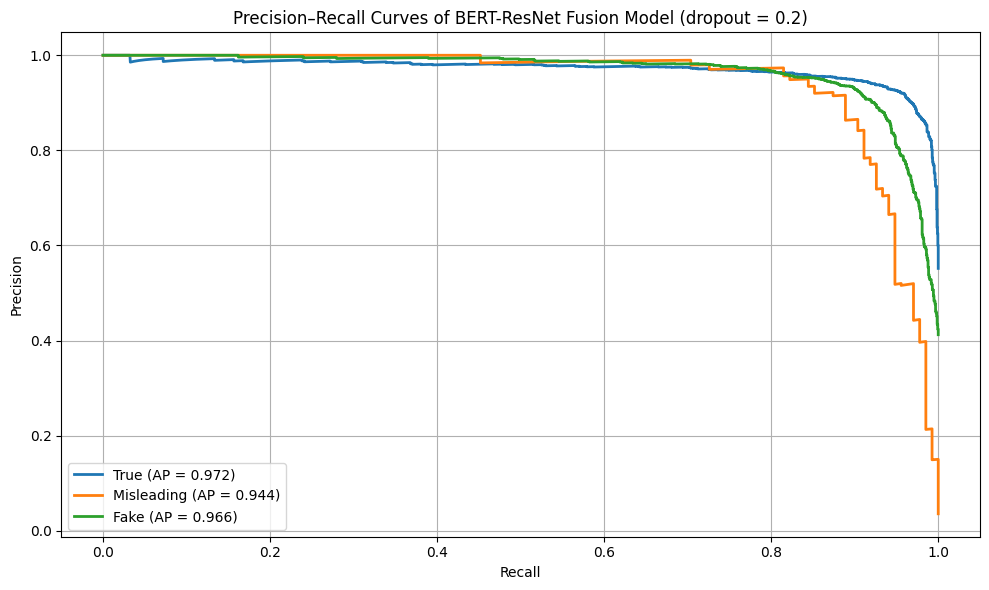

In [623]:
# plot precision-recall curves
precision, recall, avg_precision = {}, {}, {}
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], all_probs[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], all_probs[:, i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(recall[i], precision[i], lw=2, label=f"{name} (AP = {avg_precision[i]:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves of BERT-ResNet Fusion Model (dropout = 0.2)")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

Save BERT-ResNet fusion model

In [561]:
torch.save(fusion_model.state_dict(), "bert_resnet_fusion.pt")

Ablation: dropout = 0.3

BERT model

In [562]:
class TextClassifier(nn.Module):
    def __init__(self, text_model_name="bert-base-uncased", num_labels=3, freeze_bert=False):
        super().__init__()
        self.bert = BertModel.from_pretrained(text_model_name)
        self.config = self.bert.config  
        hidden = self.bert.config.hidden_size
        self.classifier = nn.Linear(hidden, num_labels)

        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        return self.classifier(pooled)

# LoRA config
config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,
    r=8,
    lora_alpha=32,
    lora_dropout=0.3,
    target_modules=["query", "value"]
)

# apply LoRA to BERT first, not to classifier
bert = BertModel.from_pretrained("bert-base-uncased")
bert = get_peft_model(bert, config)

# wrap the LoRA-BERT in classifier
text_model = TextClassifier(num_labels=3)
text_model.bert = bert


ResNet model

In [563]:
class ImageClassifier(nn.Module):
    def __init__(self, num_labels=3):
        super().__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        in_feat = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_feat, num_labels)
        )
        
        # Freeze all params
        for p in self.backbone.parameters():
            p.requires_grad = False

        # Unfreeze last residual block
        for name, p in self.backbone.layer4.named_parameters():
            p.requires_grad = True
        # Unfreeze final classifier
        for p in self.backbone.fc.parameters():
            p.requires_grad = True

    def forward(self, image):
        return self.backbone(image)


Fusion

In [564]:

class BertResNetLateFusion(nn.Module):
    def __init__(self, 
                 text_model_path="bert_text_only.pt", 
                 image_model_path="resnet_image_only.pt", 
                 num_classes=3, 
                 freeze_encoders=True):
        super().__init__()
        self.text_dropout = nn.Dropout(0.3)  
        self.img_dropout = nn.Dropout(0.3)

        # Load pretrained BERT
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.text_fc = nn.Linear(768, 512)  # reduce to 512-dim

        if text_model_path:
            try:
                text_state = torch.load(text_model_path, map_location="cpu")
                # Load only BERT weights (not classifier)
                bert_weights = {k.replace('bert.', ''): v for k, v in text_state.items() if 'bert.' in k}
                self.bert.load_state_dict(bert_weights, strict=False)
                print("Loaded pretrained BERT weights")
            except Exception as e:
                print(f"Could not load BERT weights: {e}")

        # Load pretrained ResNet
        resnet = models.resnet50(weights=None)
        resnet.fc = nn.Identity()
        self.resnet = resnet
        self.img_fc = nn.Linear(2048, 512)

        if image_model_path:
            try:
                image_state = torch.load(image_model_path, map_location="cpu")
                resnet_weights = {k.replace('resnet.', ''): v for k, v in image_state.items() if 'resnet.' in k}
                self.resnet.load_state_dict(resnet_weights, strict=False)
                print("Loaded pretrained ResNet weights")
            except Exception as e:
                print(f"Could not load ResNet weights: {e}")

        # Freeze fine-tuned encoders
        if freeze_encoders:
            for p in self.bert.parameters():
                p.requires_grad = False
            for p in self.resnet.parameters():
                p.requires_grad = False

            # Unfreeze last layers
            for name, param in self.bert.named_parameters():
                if "encoder.layer.11" in name or "pooler" in name:
                    param.requires_grad = True

            for name, param in self.resnet.named_parameters():
                if "layer4" in name:
                    param.requires_grad = True

        # Fusion head
        self.alpha = nn.Parameter(torch.tensor(0.5))  # learnable fusion weight
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    # Forward pass
    def forward(self, input_ids, attention_mask, image):
        # Text embedding
        text_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_emb = self.text_fc(text_out.pooler_output)
        text_emb = self.text_dropout(text_emb)

        # Image embedding
        img_emb = self.img_fc(self.resnet(image))
        img_emb = self.img_dropout(img_emb)

        # Weighted fusion
        fused_emb = self.alpha * text_emb + (1 - self.alpha) * img_emb
        logits = self.classifier(fused_emb)
        return logits


Train BERT

In [565]:
def evaluate_text_model(model, loader):
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu()
            all_p.extend(preds.cpu().numpy())
            all_l.extend(batch["label"].cpu().numpy())
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    avg_loss = total_loss/len(loader)
    return avg_loss, acc, f1, macro_f1


In [566]:
tr_loss = []
v_loss = []
ac = []
vac = []
f = []
vf = []
mac_f1 = []
vmac_f1 = []

def train_text_model(model, train_loader, val_loader, epochs=5, lr=1e-6): # decreased learning rate
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        avg_loss = total_loss/len(train_loader)
        tr_loss.append(avg_loss)
        ac.append(acc)
        f.append(f1)
        mac_f1.append(macro_f1)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}, Weighted F1: {f1:.4f}, Macro F1: {macro_f1:.4f}")
        
        vloss, vacc, vf1, mf1 = evaluate_text_model(model, val_loader)
        v_loss.append(vloss)
        vac.append(vacc)
        vf.append(vf1)
        vmac_f1.append(mf1)
        print(f"Validation Loss: {vloss:.4f}, Accuracy: {vacc:.4f}, Weighted F1: {vf1:.4f}, Macro F1: {mf1:.4f}")
    return model


In [567]:
text_model = TextClassifier().to(device)
text_model = train_text_model(text_model, train_text_loader, val_text_loader)

Epoch 1: 100%|██████████| 1886/1886 [22:15<00:00,  1.41it/s]


Epoch 1 | Train Loss: 0.8463, Accuracy: 0.5663, Weighted F1: 0.5690, Macro F1: 0.5094
Validation Loss: 0.6616, Accuracy: 0.6599, Weighted F1: 0.6420, Macro F1: 0.6158


Epoch 2: 100%|██████████| 1886/1886 [22:13<00:00,  1.41it/s]


Epoch 2 | Train Loss: 0.6307, Accuracy: 0.6713, Weighted F1: 0.6679, Macro F1: 0.6419
Validation Loss: 0.5616, Accuracy: 0.7139, Weighted F1: 0.7083, Macro F1: 0.7166


Epoch 3: 100%|██████████| 1886/1886 [22:18<00:00,  1.41it/s]


Epoch 3 | Train Loss: 0.5534, Accuracy: 0.7184, Weighted F1: 0.7174, Macro F1: 0.7057
Validation Loss: 0.5227, Accuracy: 0.7420, Weighted F1: 0.7357, Macro F1: 0.7328


Epoch 4: 100%|██████████| 1886/1886 [22:16<00:00,  1.41it/s]


Epoch 4 | Train Loss: 0.4951, Accuracy: 0.7490, Weighted F1: 0.7486, Macro F1: 0.7496
Validation Loss: 0.4936, Accuracy: 0.7694, Weighted F1: 0.7678, Macro F1: 0.7662


Epoch 5: 100%|██████████| 1886/1886 [22:18<00:00,  1.41it/s]


Epoch 5 | Train Loss: 0.4537, Accuracy: 0.7711, Weighted F1: 0.7711, Macro F1: 0.7811
Validation Loss: 0.4729, Accuracy: 0.7800, Weighted F1: 0.7796, Macro F1: 0.7785


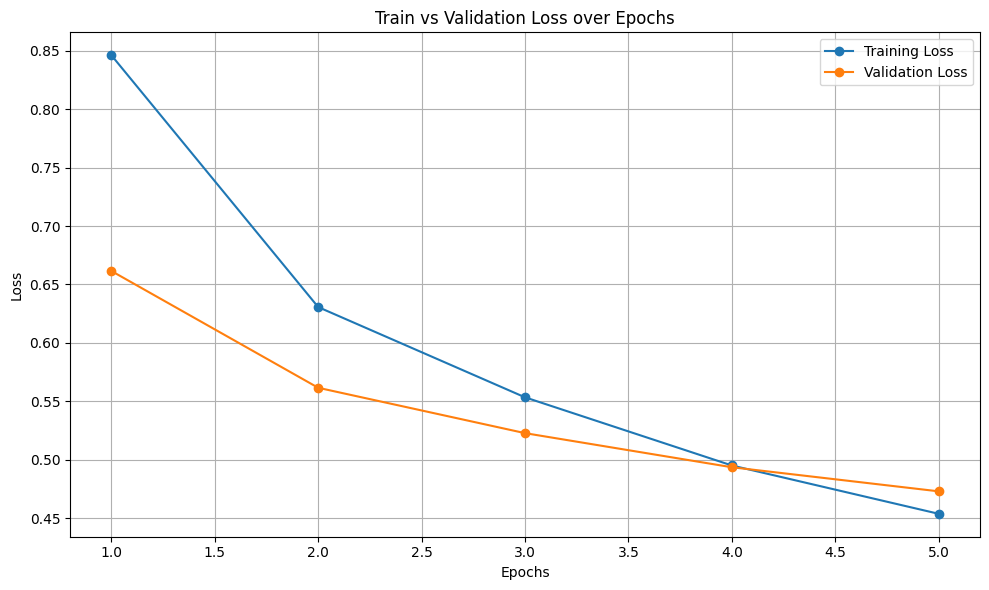

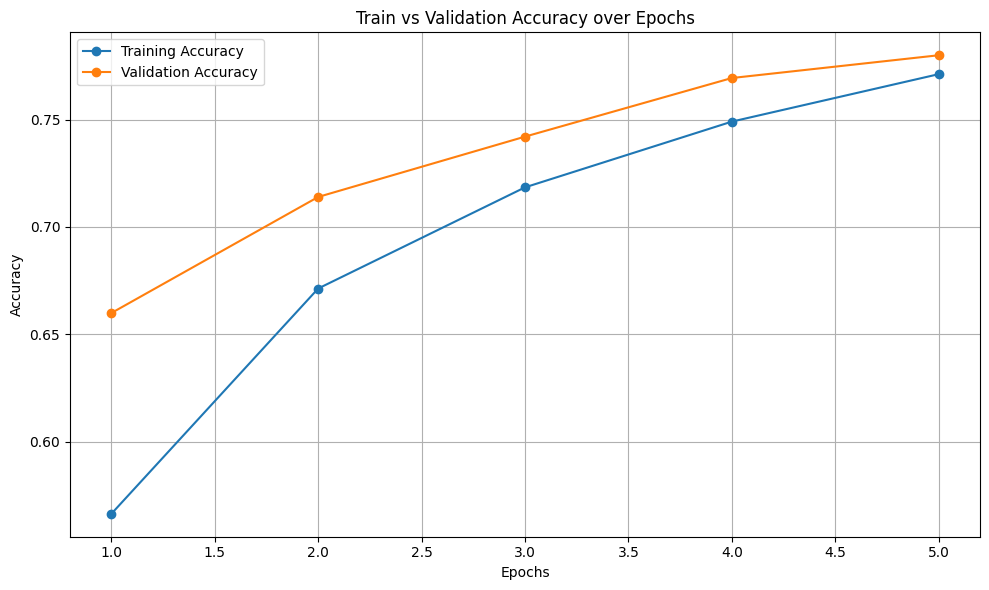

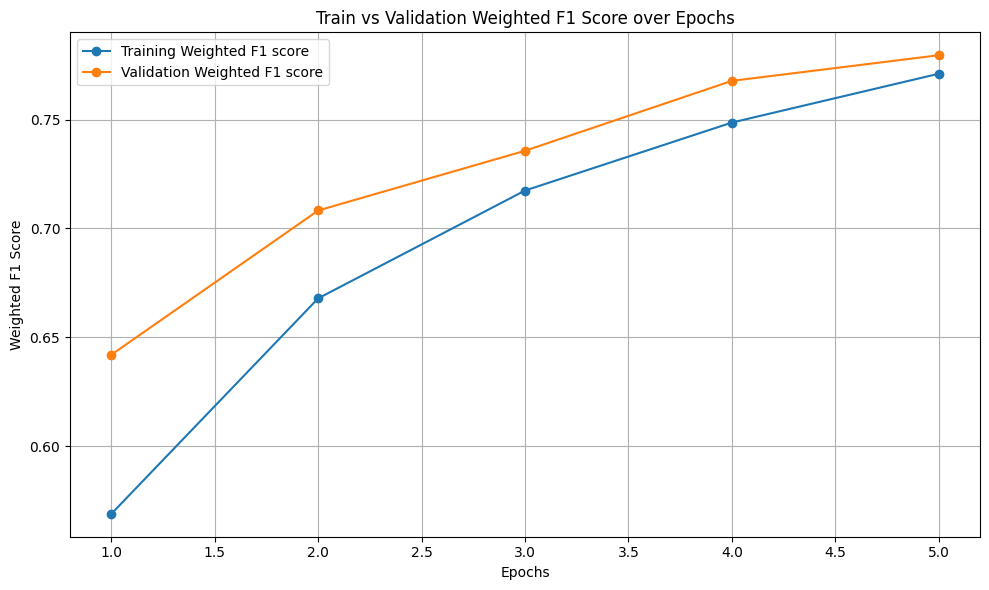

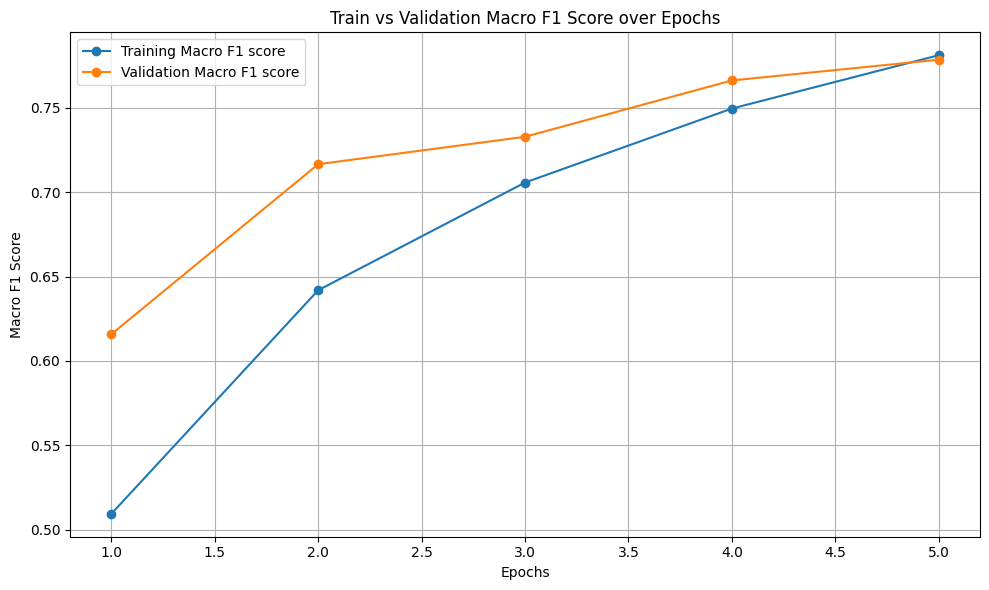

In [568]:
# Plots

# Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), tr_loss, marker='o', label='Training Loss')
plt.plot(range(1, EPOCHS+1), v_loss, marker='o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), ac, marker='o', label='Training Accuracy')
plt.plot(range(1, EPOCHS+1), vac, marker='o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation F1 Score
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), f, marker='o', label='Training Weighted F1 score')
plt.plot(range(1, EPOCHS+1), vf, marker='o', label='Validation Weighted F1 score')
plt.xlabel('Epochs')
plt.ylabel('Weighted F1 Score')
plt.title('Train vs Validation Weighted F1 Score over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation Macro F1 Score
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), mac_f1, marker='o', label='Training Macro F1 score')
plt.plot(range(1, EPOCHS+1), vmac_f1, marker='o', label='Validation Macro F1 score')
plt.xlabel('Epochs')
plt.ylabel('Macro F1 Score')
plt.title('Train vs Validation Macro F1 Score over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

BERT perfromance on Test set

In [569]:
# collect predictions and labels
all_preds, all_labels = [], []
test_loss, test_acc, test_f1, test_mf1 = evaluate_text_model(text_model, test_text_loader)
print("Perfromance of Text only BERT model on test data:")
print(f"Test loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, Weighted F1: {test_f1:.4f}, Macro F1: {test_mf1:.4f}")

Perfromance of Text only BERT model on test data:
Test loss: 0.4932, Accuracy: 0.7789, Weighted F1: 0.7781, Macro F1: 0.7878


svae bert model for later

In [570]:
torch.save(text_model.state_dict(), "bert_text_only2.pt")

In [571]:
# define label names
label_names = ['True', 'Misleading', 'Fake']

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Collect predictions and labels
all_preds, all_labels = [], []

text_model.eval() 

loop = tqdm(test_loader, desc='Testing')
with torch.no_grad():
    for batch in loop:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["label"].to(DEVICE)

        logits = text_model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
report = classification_report(all_labels, all_preds, target_names=label_names, digits=4)
print('\n=== Classification Report (BERT Model) ===\n')
print(report)

Testing: 100%|██████████| 236/236 [00:45<00:00,  5.22it/s]


=== Classification Report (BERT Model) ===

              precision    recall  f1-score   support

        True     0.8018    0.8203    0.8109      2081
  Misleading     0.7692    0.8824    0.8219       136
        Fake     0.7471    0.7145    0.7304      1555

    accuracy                         0.7789      3772
   macro avg     0.7727    0.8057    0.7878      3772
weighted avg     0.7781    0.7789    0.7781      3772



Train ResNet

In [572]:
def evaluate_image_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    with torch.no_grad():
        for batch in loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    avg_loss = total_loss/len(loader)
    return avg_loss, acc, f1, macro_f1

In [573]:
tr_loss = []
v_loss = []
ac = []
vac = []
f = []
vf = []
mac_f1 = []
vmac_f1 = []

def train_image_model(model, train_loader, val_loader, epochs=5, lr=1e-5): # reduced learning rate
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4) # added weight decay
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        avg_loss = total_loss/len(train_loader)
        tr_loss.append(avg_loss)
        ac.append(acc)
        f.append(f1)
        mac_f1.append(macro_f1)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}, Acc: {acc:.4f}, Weighted F1: {f1:.4f}, Macro F1: {macro_f1:.4f}")

        vloss, vacc, vf1, vmf1 = evaluate_image_model(model, val_loader)
        v_loss.append(vloss)
        vac.append(vacc)
        vf.append(vf1)
        vmac_f1.append(vmf1)
        print(f"Validation Loss: {vloss:.4f}, Accuracy: {vacc:.4f}, Weighted F1: {vf1:.4f}, Macro F1: {vmf1:.4f}")
    return model

In [574]:
image_model = ImageClassifier().to(device)
image_model = train_image_model(image_model, train_image_loader, val_image_loader)

Epoch 1: 100%|██████████| 1886/1886 [1:20:24<00:00,  2.56s/it]


Epoch 1 | Train Loss: 0.8885, Acc: 0.5466, Weighted F1: 0.5547, Macro F1: 0.4856
Validation Loss: 0.7561, Accuracy: 0.6074, Weighted F1: 0.6104, Macro F1: 0.5463


Epoch 2: 100%|██████████| 1886/1886 [1:19:54<00:00,  2.54s/it]


Epoch 2 | Train Loss: 0.7243, Acc: 0.6127, Weighted F1: 0.6167, Macro F1: 0.5637
Validation Loss: 0.7058, Accuracy: 0.6535, Weighted F1: 0.6486, Macro F1: 0.5946


Epoch 3: 100%|██████████| 1886/1886 [1:22:51<00:00,  2.64s/it]


Epoch 3 | Train Loss: 0.6728, Acc: 0.6481, Weighted F1: 0.6500, Macro F1: 0.6063
Validation Loss: 0.6635, Accuracy: 0.6681, Weighted F1: 0.6586, Macro F1: 0.6161


Epoch 4: 100%|██████████| 1886/1886 [1:23:04<00:00,  2.64s/it]


Epoch 4 | Train Loss: 0.6363, Acc: 0.6660, Weighted F1: 0.6665, Macro F1: 0.6295
Validation Loss: 0.6841, Accuracy: 0.6686, Weighted F1: 0.6622, Macro F1: 0.6065


Epoch 5: 100%|██████████| 1886/1886 [1:26:06<00:00,  2.74s/it]


Epoch 5 | Train Loss: 0.6077, Acc: 0.6773, Weighted F1: 0.6779, Macro F1: 0.6414
Validation Loss: 0.6747, Accuracy: 0.6689, Weighted F1: 0.6660, Macro F1: 0.6240


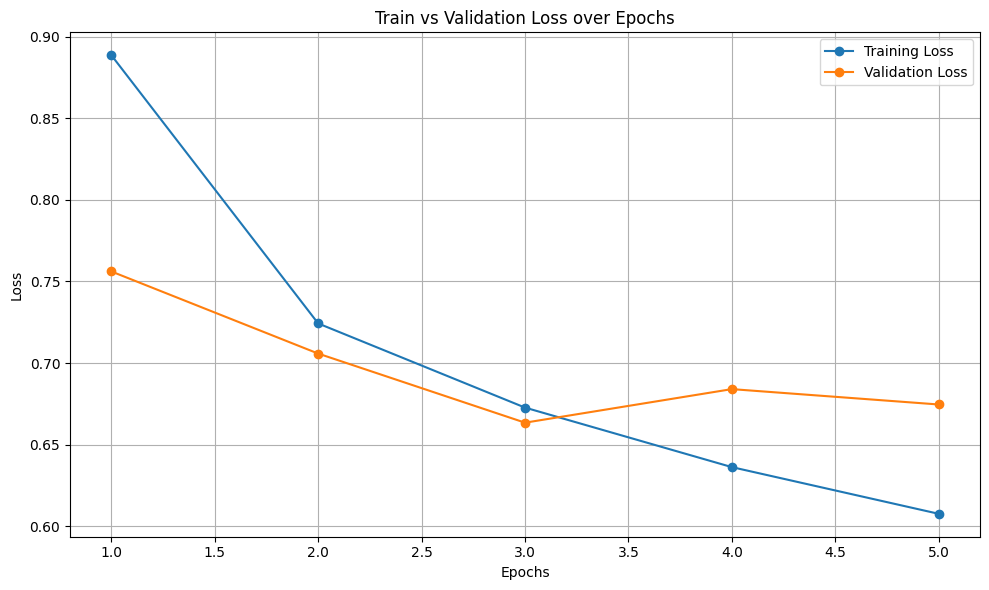

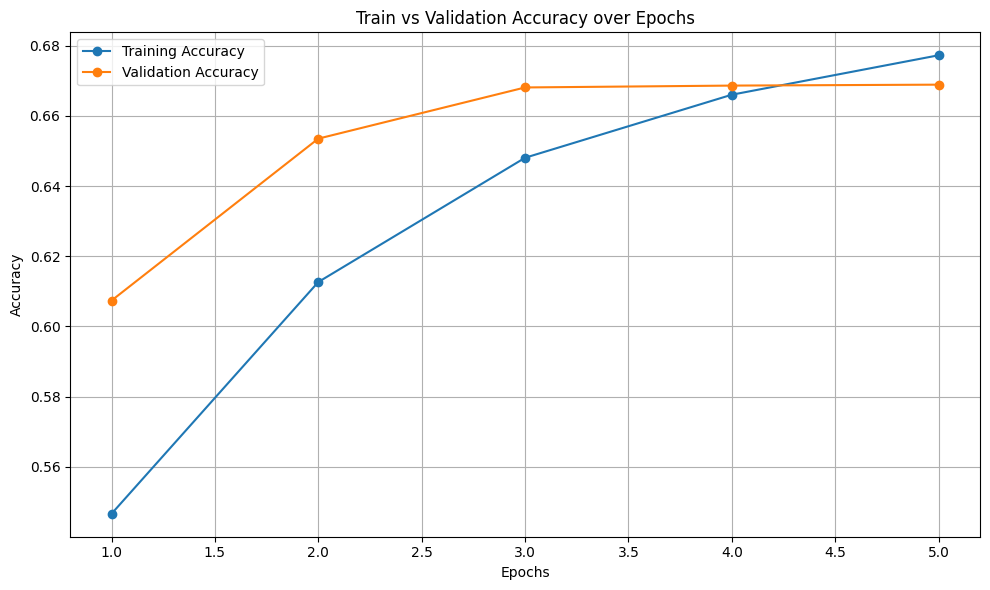

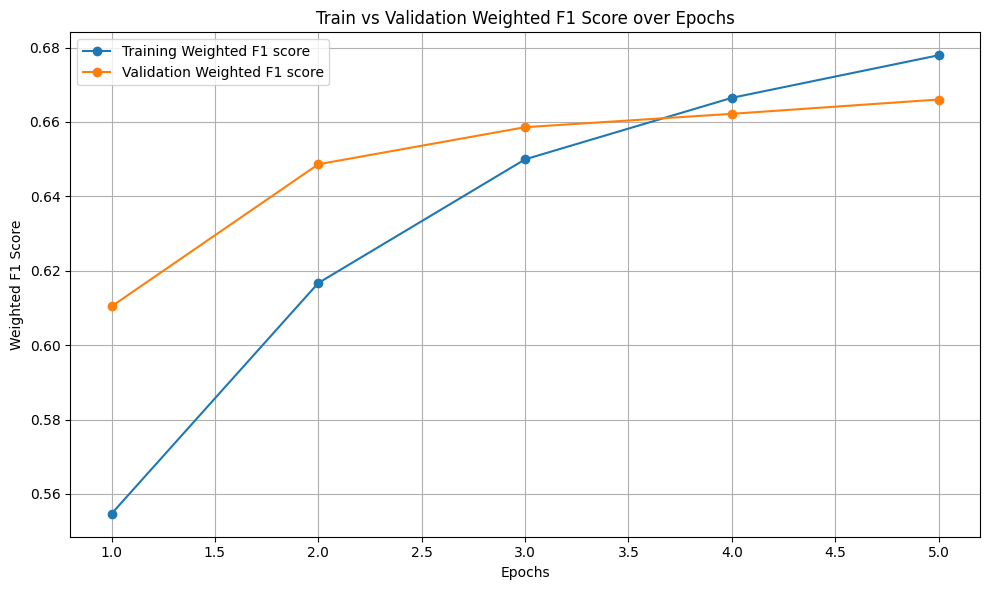

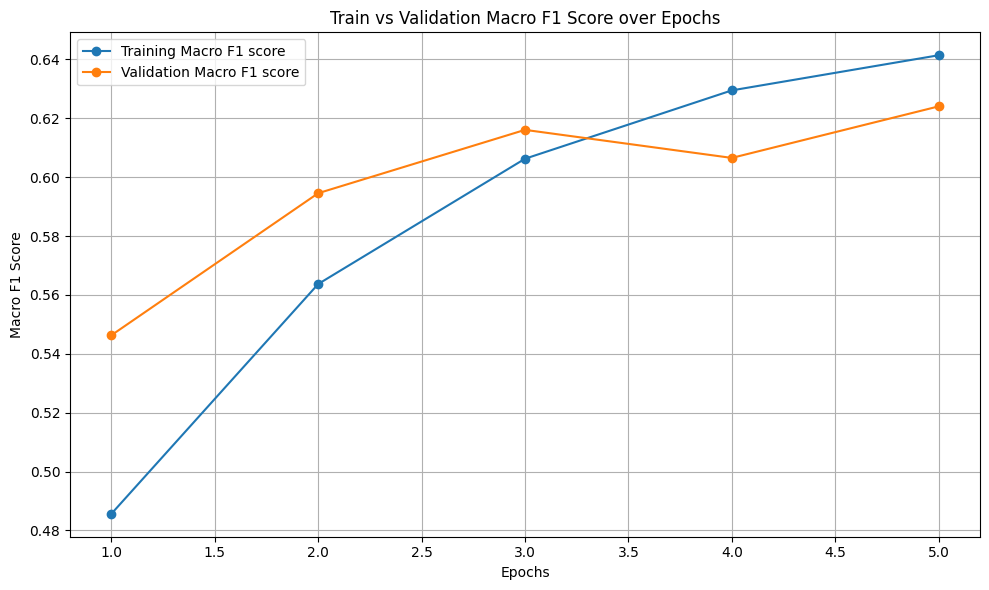

In [575]:
# plot loss, accuracy, f1

# Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), tr_loss, marker='o', label='Training Loss')
plt.plot(range(1, EPOCHS+1), v_loss, marker='o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), ac, marker='o', label='Training Accuracy')
plt.plot(range(1, EPOCHS+1), vac, marker='o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation F1 Score
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), f, marker='o', label='Training Weighted F1 score')
plt.plot(range(1, EPOCHS+1), vf, marker='o', label='Validation Weighted F1 score')
plt.xlabel('Epochs')
plt.ylabel('Weighted F1 Score')
plt.title('Train vs Validation Weighted F1 Score over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation Macro F1 Score
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), mac_f1, marker='o', label='Training Macro F1 score')
plt.plot(range(1, EPOCHS+1), vmac_f1, marker='o', label='Validation Macro F1 score')
plt.xlabel('Epochs')
plt.ylabel('Macro F1 Score')
plt.title('Train vs Validation Macro F1 Score over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

ResNet performance on Test set

In [576]:
# collect predictions and labels
all_preds, all_labels = [], []
tloss, tacc, tf1, tmf1 = evaluate_image_model(image_model, test_image_loader)
print("Perfromance of Image only ResNet model on test data:")
print(f"Test loss: {tloss:.4f}, Accuracy: {tacc:.4f}, Weighted F1: {tf1:.4f}, Macro F1: {tmf1:.4f}")

Perfromance of Image only ResNet model on test data:
Test loss: 0.6986, Accuracy: 0.6840, Weighted F1: 0.6814, Macro F1: 0.6279


In [577]:
# Define label names
label_names = ['True', 'Misleading', 'Fake']

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Collect predictions and labels
all_preds, all_labels = [], []

image_model.eval()  # ensure dropout/bn layers are in eval mode

loop = tqdm(test_loader, desc='Testing')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        
        logits = image_model(batch["image"])
        
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["label"].cpu().numpy())

# Print classification report
report = classification_report(all_labels, all_preds, target_names=label_names, digits=4)
print('\n=== Classification Report (ResNet Model) ===\n')
print(report)

Testing: 100%|██████████| 236/236 [09:49<00:00,  2.50s/it]


=== Classification Report (ResNet Model) ===

              precision    recall  f1-score   support

        True     0.7244    0.7741    0.7484      2081
  Misleading     0.4286    0.7721    0.5512       136
        Fake     0.6623    0.5550    0.6039      1555

    accuracy                         0.6837      3772
   macro avg     0.6051    0.7004    0.6345      3772
weighted avg     0.6881    0.6837    0.6817      3772



svae ResNet model

In [578]:
torch.save(image_model.state_dict(), "resnet_image_only2.pt")

Train fusion model

In [579]:
def evaluate_fusion_model(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    avg_loss = total_loss/len(loader)
    return avg_loss, acc, f1, macro_f1

In [580]:
tr_loss = []
v_loss = []
ac = []
vac = []
f = []
vf = []
mac_f1 = []
vmac_f1 = []

def train_fusion_model(model, train_loader, val_loader, epochs=5, lr=1e-6): # reduced learning rate
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-4) # added weight decay
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader, desc=f"Fusion Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        avg_loss = total_loss/len(train_loader)
        tr_loss.append(avg_loss)
        ac.append(acc)
        f.append(f1)
        mac_f1.append(macro_f1)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}, Acc: {acc:.4f}, Weighted F1: {f1:.4f}, Macro F1: {macro_f1:.4f}")

        vloss, vacc, vf1, vmf1 = evaluate_fusion_model(model, val_loader)
        v_loss.append(vloss)
        vac.append(vacc)
        vf.append(vf1)
        vmac_f1.append(vmf1)
        print(f"Validation Loss: {vloss:.4f}, Accuracy: {vacc:.4f}, Weighted F1: {vf1:.4f}, Macro F1: {vmf1:.4f}")
        print(f"Current α: {fusion_model.alpha.item():.3f}")
    return model

In [581]:
fusion_model = BertResNetLateFusion(
    text_model_path="bert_text_only2.pt",
    image_model_path="resnet_image_only2.pt",
    num_classes=3,
    freeze_encoders=True 
)

fusion_model = train_fusion_model(fusion_model, train_loader, val_loader)

Loaded pretrained BERT weights
Loaded pretrained ResNet weights


Fusion Epoch 1: 100%|██████████| 1886/1886 [1:38:59<00:00,  3.15s/it]


Epoch 1 | Train Loss: 0.7529, Acc: 0.7192, Weighted F1: 0.7169, Macro F1: 0.7323
Validation Loss: 0.5485, Accuracy: 0.7712, Weighted F1: 0.7697, Macro F1: 0.7775
Current α: 0.502


Fusion Epoch 2: 100%|██████████| 1886/1886 [1:35:29<00:00,  3.04s/it]


Epoch 2 | Train Loss: 0.4889, Acc: 0.7735, Weighted F1: 0.7731, Macro F1: 0.7871
Validation Loss: 0.4704, Accuracy: 0.7755, Weighted F1: 0.7747, Macro F1: 0.7729
Current α: 0.503


Fusion Epoch 3: 100%|██████████| 1886/1886 [1:35:39<00:00,  3.04s/it]


Epoch 3 | Train Loss: 0.4471, Acc: 0.7763, Weighted F1: 0.7765, Macro F1: 0.7907
Validation Loss: 0.4729, Accuracy: 0.7776, Weighted F1: 0.7764, Macro F1: 0.7832
Current α: 0.504


Fusion Epoch 4: 100%|██████████| 1886/1886 [1:38:12<00:00,  3.12s/it]


Epoch 4 | Train Loss: 0.4306, Acc: 0.7796, Weighted F1: 0.7797, Macro F1: 0.7971
Validation Loss: 0.4646, Accuracy: 0.7792, Weighted F1: 0.7787, Macro F1: 0.7843
Current α: 0.504


Fusion Epoch 5: 100%|██████████| 1886/1886 [1:35:01<00:00,  3.02s/it]


Epoch 5 | Train Loss: 0.4340, Acc: 0.7802, Weighted F1: 0.7804, Macro F1: 0.7924
Validation Loss: 0.4710, Accuracy: 0.7800, Weighted F1: 0.7793, Macro F1: 0.7941
Current α: 0.504


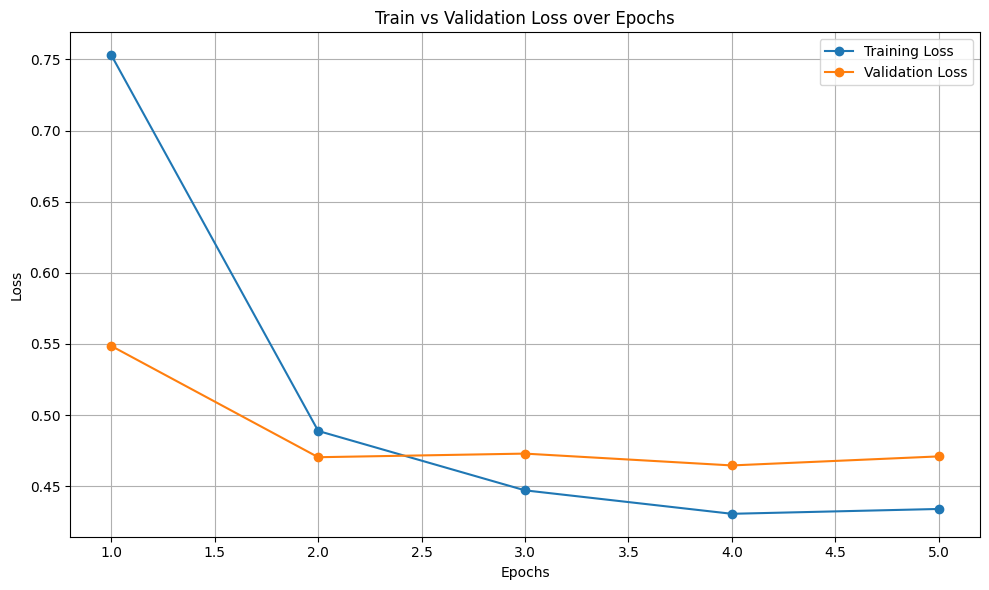

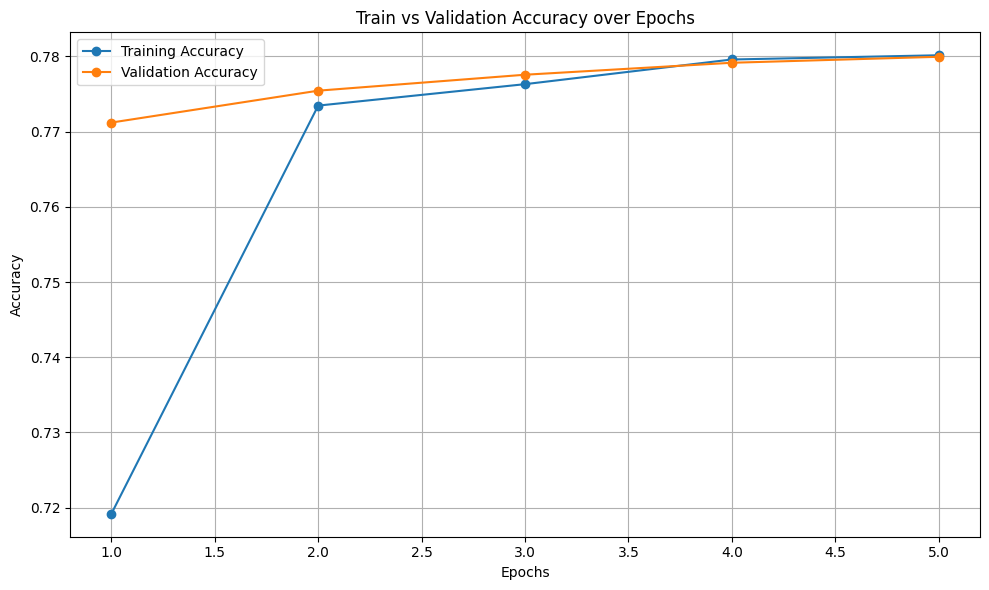

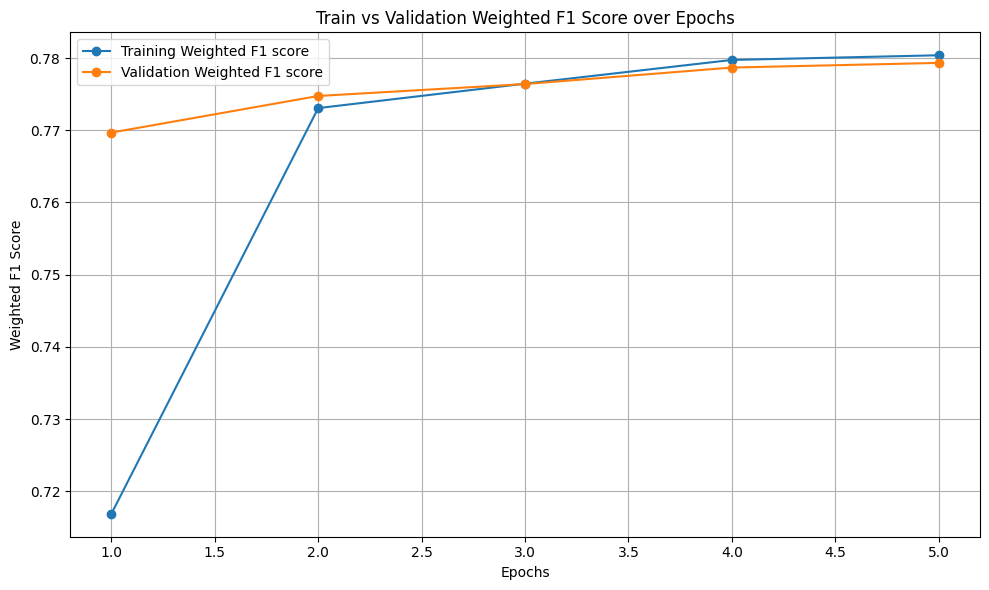

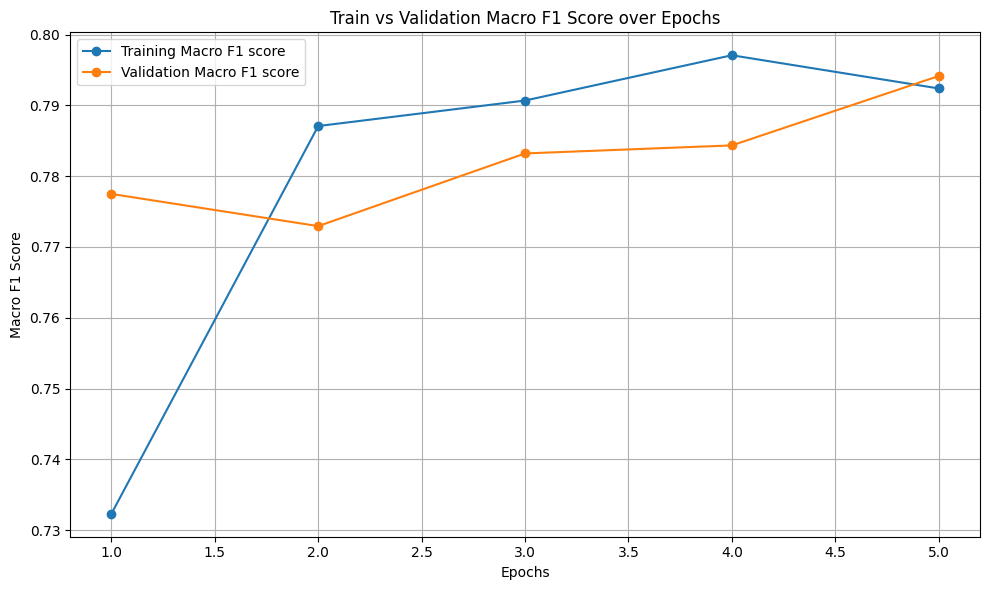

In [582]:
# plot loss, accuracy, f1

# Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), tr_loss, marker='o', label='Training Loss')
plt.plot(range(1, EPOCHS+1), v_loss, marker='o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), ac, marker='o', label='Training Accuracy')
plt.plot(range(1, EPOCHS+1), vac, marker='o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation F1 Score
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), f, marker='o', label='Training Weighted F1 score')
plt.plot(range(1, EPOCHS+1), vf, marker='o', label='Validation Weighted F1 score')
plt.xlabel('Epochs')
plt.ylabel('Weighted F1 Score')
plt.title('Train vs Validation Weighted F1 Score over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Train vs Validation Macro F1 Score
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), mac_f1, marker='o', label='Training Macro F1 score')
plt.plot(range(1, EPOCHS+1), vmac_f1, marker='o', label='Validation Macro F1 score')
plt.xlabel('Epochs')
plt.ylabel('Macro F1 Score')
plt.title('Train vs Validation Macro F1 Score over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Fusion model performance on test set

In [583]:
# collect predictions and labels
all_preds, all_labels = [], []
tloss, tacc, tf1, tmf1 = evaluate_fusion_model(fusion_model, test_loader)
print("Perfromance of Image and Text BERT-ResNet Fusion model on test data:")
print(f"Test loss: {tloss:.4f}, Accuracy: {tacc:.4f}, Weighted F1: {tf1:.4f}, Macro F1: {tmf1:.4f}")

Perfromance of Image and Text BERT-ResNet Fusion model on test data:
Test loss: 0.4919, Accuracy: 0.7850, Weighted F1: 0.7840, Macro F1: 0.7965


In [584]:
# Define label names
label_names = ['True', 'Misleading', 'Fake']

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Collect predictions and labels
all_preds, all_labels = [], []

fusion_model.eval()  

loop = tqdm(test_loader, desc='Testing')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        
        logits = fusion_model(batch["input_ids"], batch["attention_mask"], batch["image"])
        
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["label"].cpu().numpy())

# Print classification report
report = classification_report(all_labels, all_preds, target_names=label_names, digits=4)
print('\n=== Classification Report (ResNet Model) ===\n')
print(report)

Testing: 100%|██████████| 236/236 [10:59<00:00,  2.79s/it]


=== Classification Report (ResNet Model) ===

              precision    recall  f1-score   support

        True     0.8006    0.8313    0.8157      2081
  Misleading     0.7778    0.8750    0.8235       136
        Fake     0.7579    0.7106    0.7335      1555

    accuracy                         0.7831      3772
   macro avg     0.7787    0.8056    0.7909      3772
weighted avg     0.7821    0.7831    0.7821      3772



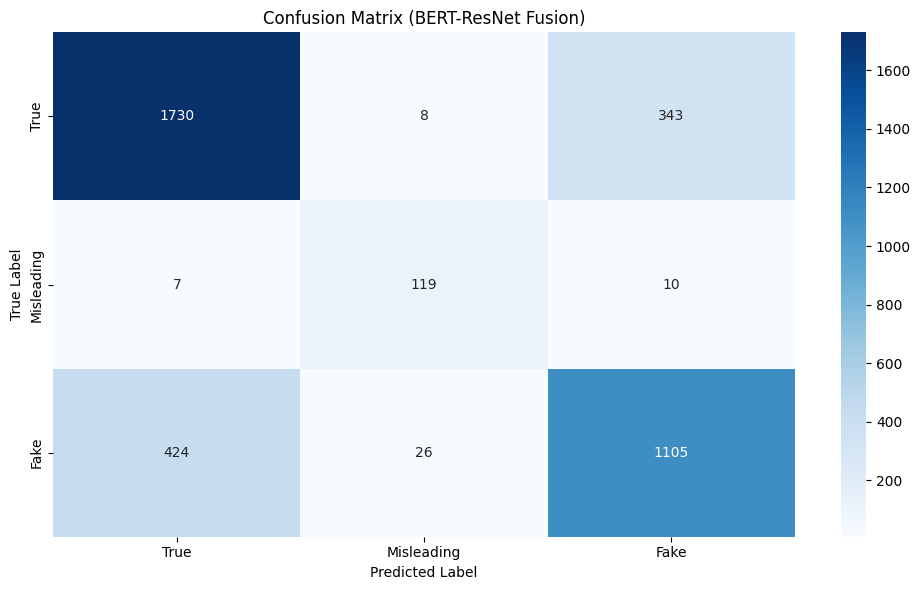

In [585]:
# plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (BERT-ResNet Fusion)')
plt.tight_layout()
plt.show()

Plot ROC-AUC curves

In [586]:
# binarize labels for ROC and precision-recall curves
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]

# get prediction probabilities
all_probs = []
loop = tqdm(test_loader, desc='Collecting probabilities')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        logits = model(batch["input_ids"], batch["attention_mask"], batch["image"])
        probs = torch.softmax(logits, dim=-1)
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)

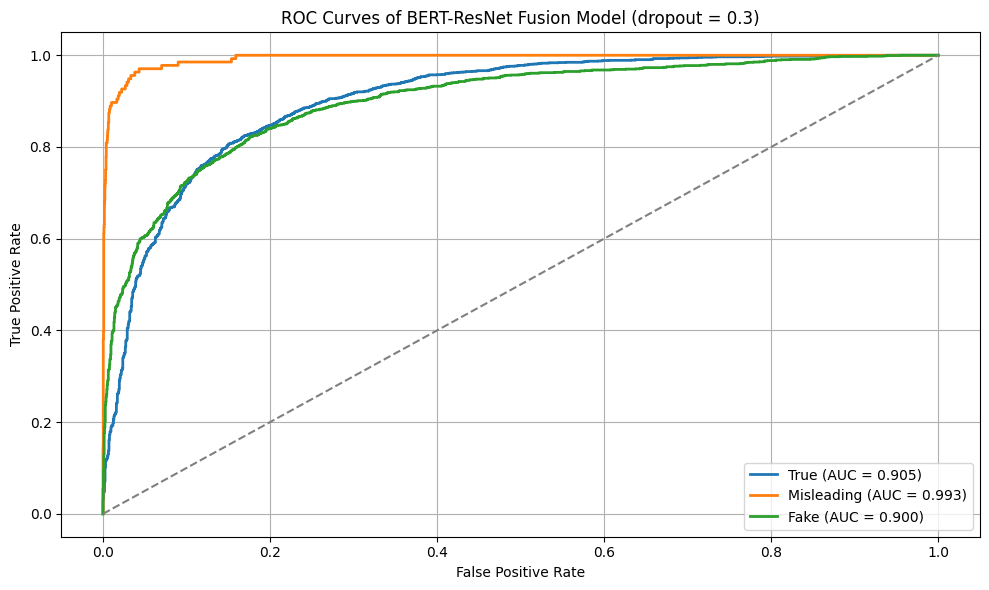

In [589]:
# plot ROC curves
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{name} (AUC = {roc_auc[i]:.3f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves of BERT-ResNet Fusion Model (dropout = 0.3)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

Plot precision-recall curves

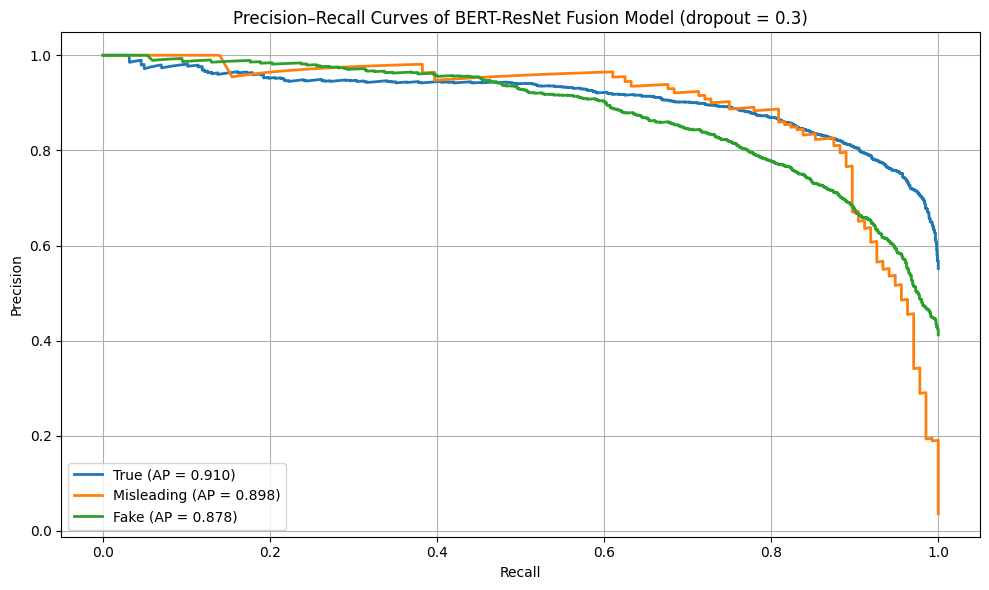

In [590]:
# plot precision-recall curves
precision, recall, avg_precision = {}, {}, {}
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], all_probs[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], all_probs[:, i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(recall[i], precision[i], lw=2, label=f"{name} (AP = {avg_precision[i]:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves of BERT-ResNet Fusion Model (dropout = 0.3)")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()